## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, VotingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
import warnings

# To ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


pd.set_option('display.max_columns', None)
data=pd.read_csv('p1_movie_metadata.csv')


## Preprocessing

We perform the following preprocessing steps:

1. Changing Data types of certain columns to strings and dropping duplicate entries.

2. Dropping unnecessary columns which would not be required by our Machine Learning Model.

3. Since Director name is Important, and the number of rows where Director name is not present is around 104, therefore we drop these rows.

4. We also fill Missing values in Numerical columns with KNN (K-Nearest Neighbours) Imputer.

5. For categorical columns, we fill missing values with Mode.


In [2]:

data['color']=data['color'].astype(str)
data['actor_2_name']=data['color'].astype(str)
data['actor_1_name']=data['color'].astype(str)
data['movie_title']=data['color'].astype(str)
data['actor_3_name']=data['color'].astype(str)


print(data.shape)
data.drop_duplicates(inplace=True)
print(data.shape)


data.drop(columns=['facenumber_in_poster','plot_keywords','movie_imdb_link','num_user_for_reviews','country','aspect_ratio'],inplace=True)

data = data.dropna(subset=['director_name'])
# data=data.dropna(subset=['genres'])


(5043, 28)
(4998, 28)


In [3]:
# Fill missing values in numerical columns with KNN Imputer
numerical_cols = ['budget', 'gross', 'num_critic_for_reviews', 'duration', 'actor_3_facebook_likes', 'actor_1_facebook_likes']
knn_imputer = KNNImputer()
data[numerical_cols] = knn_imputer.fit_transform(data[numerical_cols])

# Fill missing values in categorical columns with mode
categorical_cols = ['color', 'actor_2_name', 'actor_1_name', 'language']
mode_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = mode_imputer.fit_transform(data[categorical_cols])

In [4]:
data.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'language', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes'],
      dtype='object')

## Visualisations 

Let us study this dataset through some visualisation and understand which features are important to us!


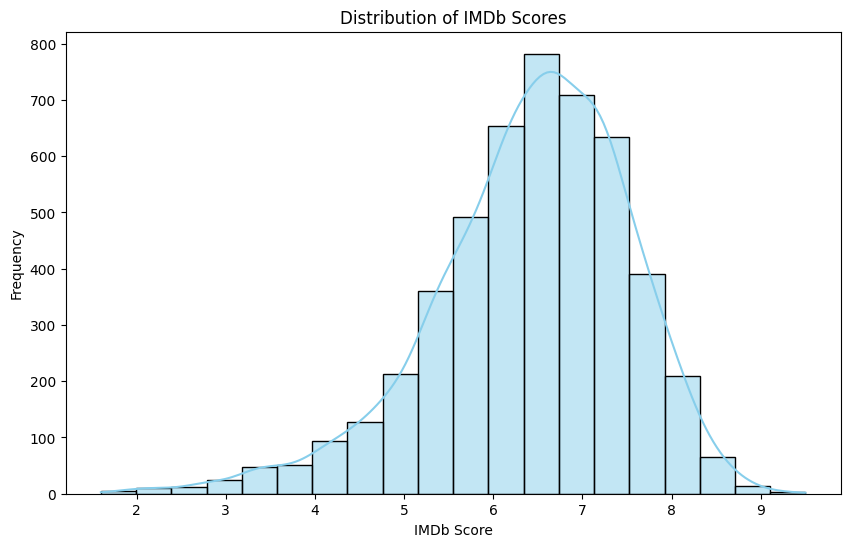

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of IMDb scores
plt.figure(figsize=(10, 6))
sns.histplot(data['imdb_score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of IMDb Scores')
plt.xlabel('IMDb Score')
plt.ylabel('Frequency')
plt.show()

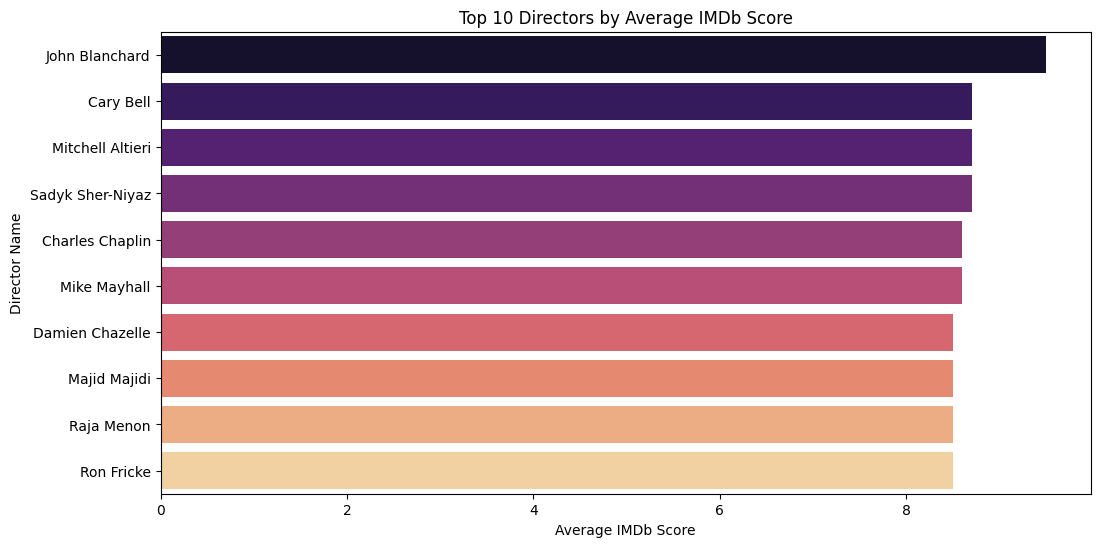

In [6]:
# Visualize the top 10 directors with the highest average IMDb scores
top_directors = data.groupby('director_name')['imdb_score'].mean().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_directors.values, y=top_directors.index, palette='magma')
plt.title('Top 10 Directors by Average IMDb Score')
plt.xlabel('Average IMDb Score')
plt.ylabel('Director Name')
plt.show()

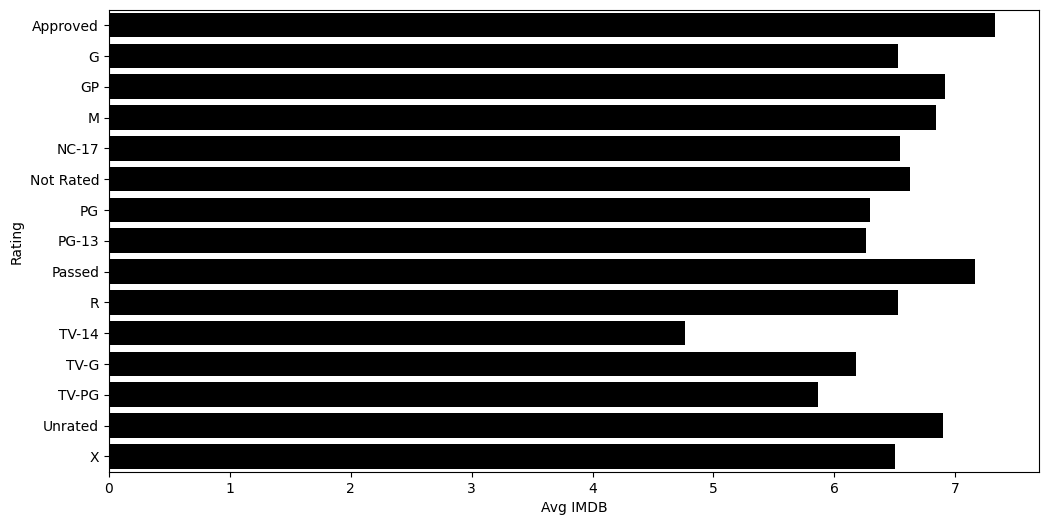

In [7]:
# content rating by imdb
plt.figure(figsize=(12,6))
avg_earn1 = data.groupby('content_rating')['imdb_score'].mean().reset_index()
sns.barplot(data=avg_earn1, y='content_rating', x='imdb_score', color='black')
plt.xlabel('Avg IMDB')
plt.ylabel('Rating')
plt.show()

## Correlation Analysis with Continuous Variables


In [8]:
columns = data.columns
discrete = []
continuous = []
for i in columns:
    if data[i].dtype =='object':
        discrete.append(i)
    else:
        continuous.append(i)

<Axes: >

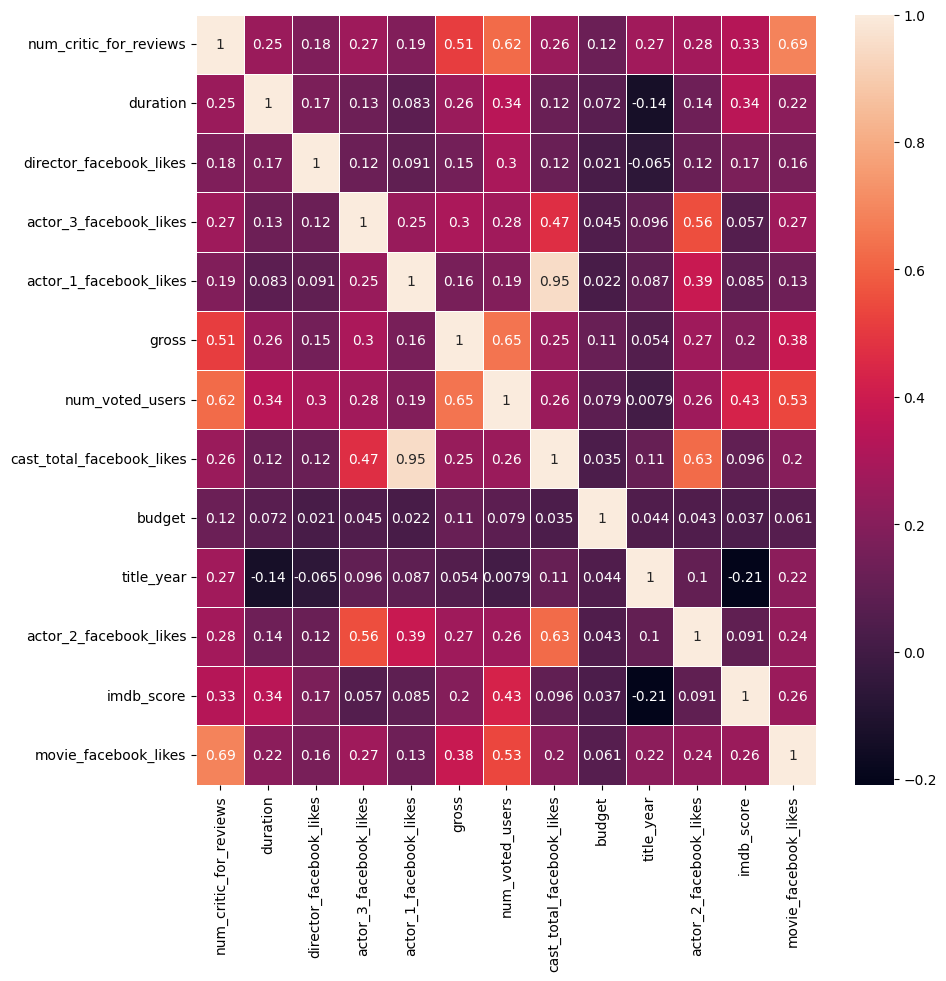

In [9]:
data_corr = data[continuous].dropna().corr()


fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data_corr,
            xticklabels=data_corr.columns.values,
            yticklabels=data_corr.columns.values,
           annot=True, linewidths=.5, ax=ax)

From Above visualisations, we conclude that while some features are useful (such as imdb_score, content_rating)
there is a need for creating more custom features that will satisfy our usecase

## Features

The Goal is to Develop an ML model which, given the name of a director (and other parameters), predicts the release year of his next movie along with its probable genres. We can approach it as two separate tasks: one for predicting the release year (regression problem) and another for predicting the genres (label classification problem).

For these tasks, we create new features that help us better serve as inputs to the machine learning model:

1. **`director_experience`**: Count how many movies each director has made to see how much experience they have.

2. **`director_avg_imdb_score`**: Find the average rating of movies made by each director to see how good their movies usually are.

3. **`movie_success_ratio`**: Compare how much money a movie makes to how much it cost to see if it was successful.

4. **`year_since_last_movie`**: See how long it's been since each director made their last movie to understand how active they are.

5. **`target_genre`**: Figure out what type of movie each one is to understand what kinds of movies directors like to make.

6. **`genre_frequency`**: Count how often each director makes movies in each genre to see what they focus on.

7. **`actor_1_genre_avg_score`**: See how well movies with the main actor do in different types of movies.

8. **`language_performance`**: Find out how well movies in each language do to see if language affects how much people like a movie.

9. **`normalized_actor_popularity_score`**: Compare how popular actors are by adjusting for differences in how popular actors usually are.


In [10]:
# Create new features

data['director_experience'] = data.groupby('director_name')['director_name'].transform('count')
data['director_avg_imdb_score'] = data.groupby('director_name')['imdb_score'].transform('mean')
data['movie_success_ratio'] = data['gross'] / data['budget']
data['year_since_last_movie'] = data.groupby('director_name')['title_year'].diff(-1).fillna(0)
data['target_genre'] = data['genres'].str.split('|').str[0]
data['genre_frequency'] = data.groupby(['director_name', 'target_genre'])['target_genre'].transform('count')
actor_genre_performance = data.groupby(['actor_1_name', 'target_genre'])['imdb_score'].mean().reset_index()
actor_genre_performance.rename(columns={'imdb_score': 'actor_1_genre_avg_score'}, inplace=True)
data = data.merge(actor_genre_performance, on=['actor_1_name', 'target_genre'], how='left')
language_performance = data.groupby('language')['imdb_score'].mean().reset_index()
data = data.merge(language_performance, on='language', how='left')
data.rename(columns={'imdb_score': 'language_performance'}, inplace=True)
data['actor_popularity_score'] = data['actor_1_facebook_likes'] + data['actor_2_facebook_likes'] + data['actor_3_facebook_likes']
mean = data['actor_popularity_score'].mean()
std_dev = data['actor_popularity_score'].std()
data['normalized_actor_popularity_score'] = (data['actor_popularity_score'] - mean) / std_dev

data.drop(columns=['genres'],inplace=True)
data.drop(columns=['actor_1_name','color','actor_3_name','actor_2_name','movie_title','gross','budget','actor_1_facebook_likes','actor_3_facebook_likes','actor_2_facebook_likes','actor_popularity_score','language'],inplace=True)

genre_list=pd.Series(data['target_genre'].unique()).tolist()



### Chi-Square Test

1. **Chi-square Test for Independence**: We conduct a chi-square test to assess the association between movie genres and content ratings.

2. **Cross-tabulation**: We create a contingency table of movie genres and content ratings to visualize their frequency distribution.

3. **Visualization**: We use a stacked bar plot to display the distribution of content ratings within each genre category, revealing potential patterns or associations.


Chi-square Test Results:
Chi-square statistic: 1884.6863079860266
p-value: 2.0354053149509324e-247


<Axes: title={'center': 'Genres vs. Content Ratings'}, xlabel='target_genre'>

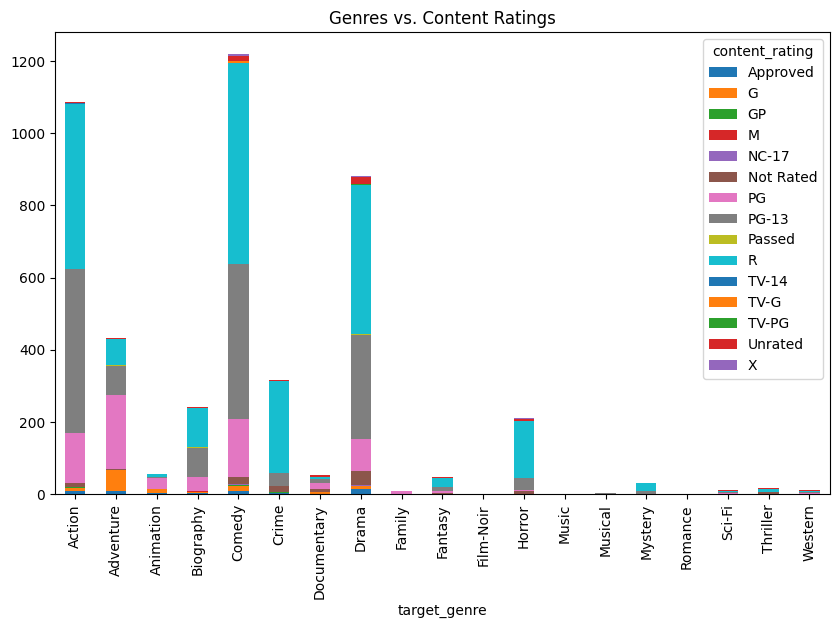

In [11]:
from scipy.stats import chi2_contingency
#Lets check that using chi square test
#: Chi-square Test for Independence
contingency_table = pd.crosstab(data['target_genre'], data['content_rating'])
chi2, p, _, _ = chi2_contingency(contingency_table)

print("\nChi-square Test Results:")
print("Chi-square statistic:", chi2)
print("p-value:", p)


# Cross-tabulate genres and content ratings
cross_tab = pd.crosstab(data['target_genre'], data['content_rating'])

# Visualize the cross-tabulated data
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6), title='Genres vs. Content Ratings')

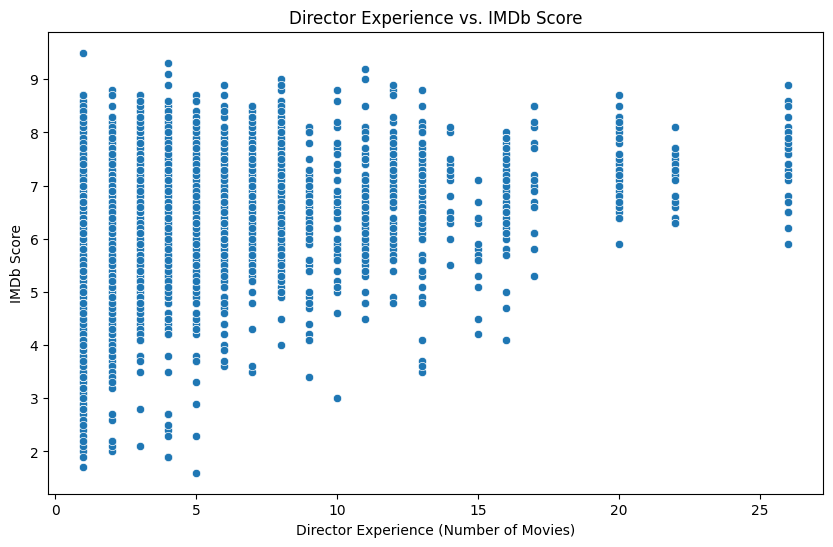

In [12]:

# Visualize the relationship between director experience and IMDb score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='director_experience', y='imdb_score_x', data=data)
plt.title('Director Experience vs. IMDb Score')
plt.xlabel('Director Experience (Number of Movies)')
plt.ylabel('IMDb Score')
plt.show()

#output- The plot shows us that directors with higher experience have better IMDb scores!

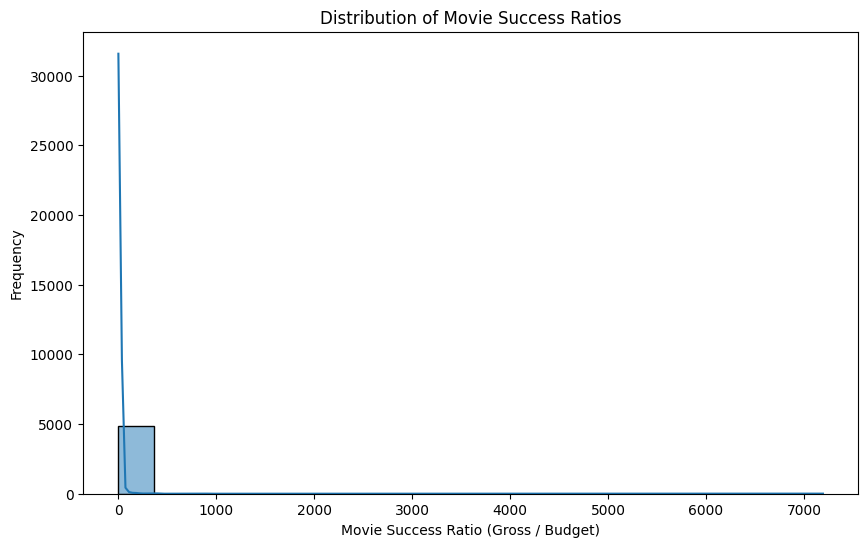

In [13]:
# Visualize the distribution of movie success ratios
plt.figure(figsize=(10, 6))
sns.histplot(data['movie_success_ratio'], bins=20, kde=True)
plt.title('Distribution of Movie Success Ratios')
plt.xlabel('Movie Success Ratio (Gross / Budget)')
plt.ylabel('Frequency')
plt.show()

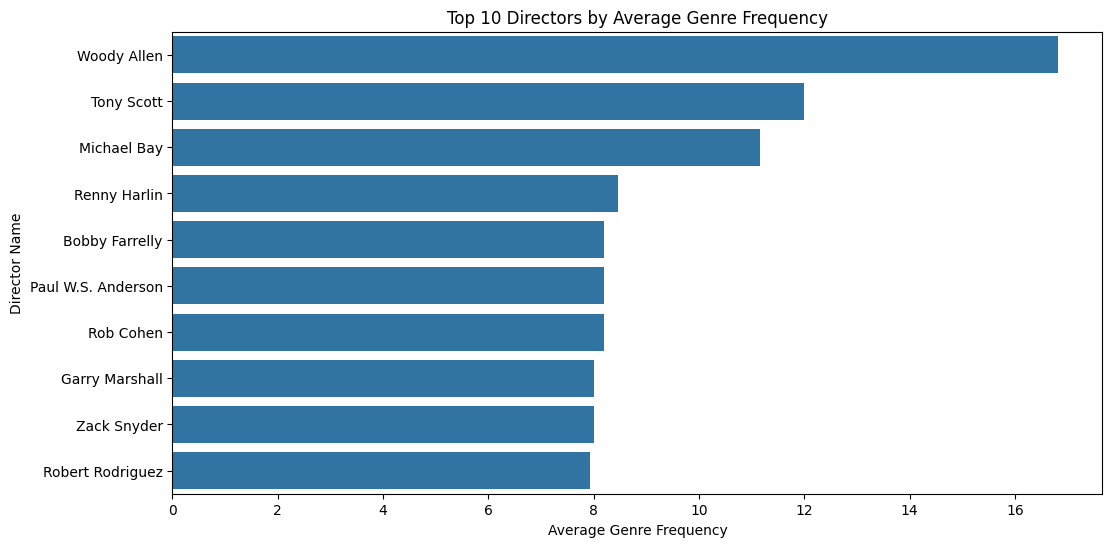

In [14]:
# Visualize the genre frequency for different directors
top_directors = data.groupby('director_name')['genre_frequency'].mean().nlargest(10).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='genre_frequency', y='director_name', data=top_directors)
plt.title('Top 10 Directors by Average Genre Frequency')
plt.xlabel('Average Genre Frequency')
plt.ylabel('Director Name')
plt.show()

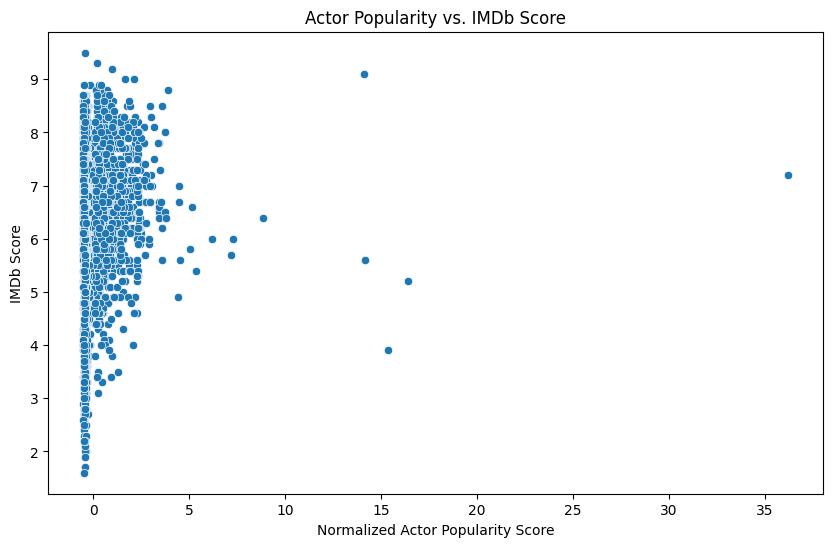

In [15]:
# Visualize the relationship between actor popularity and IMDb score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='normalized_actor_popularity_score', y='imdb_score_x', data=data)
plt.title('Actor Popularity vs. IMDb Score')
plt.xlabel('Normalized Actor Popularity Score')
plt.ylabel('IMDb Score')
plt.show()

In [16]:
#Features used for training
data.columns
# Assuming df is your DataFrame
data.rename(columns={'imdb_score_x': 'imdb_score'}, inplace=True)
data.drop(columns=['imdb_score_y'], inplace=True)

In [17]:

data.to_csv('FinalData.csv',index=False)

## Encoding 

One Hot Encoding Categorical Features such as `director_name`, `content_rating`, `target_genre`.


In [18]:

# Encode categorical features
categorical_features = ['director_name', 'content_rating', 'target_genre']
data.dropna(subset=categorical_features, inplace=True)
label_encoders = {col: LabelEncoder() for col in categorical_features}
for col in categorical_features:
    data[col].dropna(inplace=True)
    data[col] = label_encoders[col].fit_transform(data[col])

# One-hot encode categorical features
categorical_encoded = pd.get_dummies(data[categorical_features], drop_first=True)
data = pd.concat([data.drop(categorical_features, axis=1), categorical_encoded], axis=1)

## Classification Model

1. **Data Splitting**: We split the dataset into features (`X`) and targets (`y_year` for regression, `y_genres` for classification) using the `train_test_split` function from scikit-learn.

2. **Label Encoding**: We encode the target labels (`y_train`) using `LabelEncoder` to prepare them for classification.

3. **Model Training and Evaluation**: We train two classifiers, RandomForestClassifier and XGBClassifier, using the training data (`X_train` and `y_train`). Then, we evaluate each classifier's performance on the test data (`X_test` and `y_test`) using accuracy and F1-score metrics.

4. **Model Evaluation Metrics**: We calculate and print the accuracy and F1-score for each classifier. These metrics provide insights into how well the models are performing in classifying movie genres.


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score


# Split the data into features and targets
X = data.drop(['title_year', 'target_genre'], axis=1)
y_year = data['title_year']
y_genres = data['target_genre']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_genres, test_size=0.2, random_state=42)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
# Genre Classification
print("Genre Classification")
classifiers = [
    RandomForestClassifier(random_state=42),
    XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y_train)), random_state=42)
]


for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{clf.__class__.__name__} - Accuracy: {accuracy:.3f}, F1-score: {f1:.3f}")


Genre Classification
RandomForestClassifier - Accuracy: 0.948, F1-score: 0.942
XGBClassifier - Accuracy: 0.985, F1-score: 0.984


In [26]:
import pandas as pd

def predict_next_movie(director_label, genre_model, df, genre_list):
    # Extract relevant features from the dataframe
    director_data = df[df['director_name'] == director_label]
    if director_data.empty:
        print("Director not found in the dataset.")
        return None

    # Extract the necessary features
    features = {
        'num_critic_for_reviews': director_data['num_critic_for_reviews'].max(),
        'duration': director_data['duration'].max(),
        'director_facebook_likes': director_data['director_facebook_likes'].max(),
        'num_voted_users': director_data['num_voted_users'].max(),
        'cast_total_facebook_likes': director_data['cast_total_facebook_likes'].max(),
        'imdb_score': director_data['imdb_score'].max(),
        'movie_facebook_likes': director_data['movie_facebook_likes'].max(),
        'director_experience': director_data['director_experience'].max(),
        'director_avg_imdb_score': director_data['director_avg_imdb_score'].max(),
        'movie_success_ratio': director_data['movie_success_ratio'].max(),
        'year_since_last_movie': director_data['year_since_last_movie'].max(),
        'genre_frequency': director_data['genre_frequency'].max(),
        'actor_1_genre_avg_score': director_data['actor_1_genre_avg_score'].max(),
        'normalized_actor_popularity_score': director_data['normalized_actor_popularity_score'].max(),
        'director_name': director_label,
        'content_rating': director_data['content_rating'].value_counts().idxmax()
    }

    # Include one-hot encoded categorical features
    director_name_dummies = pd.get_dummies(pd.Series(director_label), prefix='director_name', drop_first=True)
    content_rating_dummies = pd.get_dummies(director_data['content_rating'], drop_first=True)
    features.update(director_name_dummies.to_dict())
    features.update(content_rating_dummies.to_dict())

    # Convert features to a list for model prediction
    feature_values = list(features.values())
    next_movie_features = [feature_values]

    # Predict the genre(s) for the next movie
    predicted_genre_labels = genre_model.predict(next_movie_features)
    predicted_genres = convert_labels_to_genres(predicted_genre_labels[0], genre_list)

    return predicted_genres



def convert_labels_to_genres(predicted_label, genre_list):
    predicted_genres = []
    
    if isinstance(predicted_label, np.ndarray):
        # Case 1: predicted_label is a numpy array
        for label in predicted_label:
            genre_indices = np.where(label == 1)[0]  # Get indices where label is 1
            for i in genre_indices:
                predicted_genres.append(genre_list[i])
    else:
        # Case 2: predicted_label is a single integer
        genre_indices = np.where(predicted_label == 1)[0]  # Get indices where label is 1
        for i in genre_indices:
            predicted_genres.append(genre_list[i])
    
    return predicted_genres

In [37]:
# Assuming you have loaded the necessary data and model
xgb_genre_classifier = classifiers[1]
predicted_genres = predict_next_movie(2171,xgb_genre_classifier, data, genre_list)
print(f"Predicted genres for next movie: {predicted_genres}")

Predicted genres for next movie: ['Action']


C:\Users\harsh\AppData\Local\Temp\ipykernel_13336\3488239899.py:59: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  genre_indices = np.where(predicted_label == 1)[0]  # Get indices where label is 1


## Regressor Model


 **Identification and Scaling of Numerical Features**: First, we identified the numerical features in the dataset (`X`) using `select_dtypes`. Then, we scaled these numerical features using `StandardScaler()`.


## 1. Defining ML Models

The code starts by defining two regression models: Random Forest Regressor and XGBoost Regressor. These models will be used for predicting the release year of movies.



## 2. Grid Search for Hyperparameter Tuning

To find the optimal hyperparameters for each model, a grid search is performed using the `GridSearchCV` class from scikit-learn. Separate hyperparameter grids are defined for Random Forest Regressor and XGBoost Regressor, and the grid search is performed on the training data `X_train` and `y_train`.


The best hyperparameters and the corresponding RMSE scores are printed for each model.

## 3. Cross-Validation and Ensemble

Next, cross-validation is performed on the regressors using the `cross_val_score` function. The mean RMSE scores are calculated and printed for each regressor.



Finally, an Ensemble Voting Regressor is created by combining the Random Forest Regressor and XGBoost Regressor. The ensemble regressor is fitted on the entire dataset `X` and `y_year`, and predictions are made. The RMSE score for the ensemble regressor is calculated and printed.



In [25]:


# Identify and scale numerical features
numerical_features = X.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

print("\nRelease Year Prediction")
regressors = [
    RandomForestRegressor(random_state=42),
    XGBRegressor(random_state=42)
]

from sklearn.model_selection import GridSearchCV

# Grid search for Random Forest Regressor
rf_param_grid = {
    'n_estimators': [150,200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5,7,10],
    'min_samples_leaf': [1, 2, 4,6]
}

rf_reg = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(rf_reg, param_grid=rf_param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

print(f"Best Random Forest parameters: {rf_grid_search.best_params_}")
print(f"Best Random Forest RMSE: {-rf_grid_search.best_score_:.2f}")

# Grid search for XGBoost Regressor
xgb_param_grid = {
    'max_depth': [3, 5, 7,9],
    'n_estimators': [150],
    'learning_rate': [0.01, 0.05, 0.1,],
    'gamma': [0, 0.1, 0.2,0.3]
}

xgb_reg = XGBRegressor(random_state=42)
xgb_grid_search = GridSearchCV(xgb_reg, param_grid=xgb_param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

print(f"Best XGBoost parameters: {xgb_grid_search.best_params_}")
print(f"Best XGBoost RMSE: {-xgb_grid_search.best_score_:.2f}")

# Cross-validation for release year prediction
print("\nCross-validation for release year prediction")
for reg in regressors:
    cv_scores = cross_val_score(reg, X, y_year, cv=5, scoring='neg_root_mean_squared_error')
    print(f"{reg.__class__.__name__} - Mean RMSE: {-cv_scores.mean():.2f}")

# Ensemble release year prediction
ensemble_reg = VotingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                                           ('xgb', XGBRegressor(random_state=42))],
                               )
ensemble_reg.fit(X, y_year)
ensemble_preds = ensemble_reg.predict(X)
ensemble_rmse = mean_squared_error(y_year, ensemble_preds, squared=False)
print(f"Ensemble Regressor RMSE: {ensemble_rmse:.2f}")



Release Year Prediction


KeyboardInterrupt: 

## Evaluating on Test Set

In [ ]:
# Calculate RMSE of XGB on the test set
xgb_grid_search_test=xgb_grid_search.predict(X_test)
test_rmse = mean_squared_error(y_test, xgb_grid_search_test, squared=False)
print(f"XGBoost RMSE: {test_rmse:.2f}")


# Calculate RMSE of RF on the test set
rf_grid_search_test=rf_grid_search.predict(X_test)
test_rmse = mean_squared_error(y_test, rf_grid_search_test, squared=False)
print(f"Random Forest RMSE: {test_rmse:.2f}")


# Make predictions on the test set
ensemble_preds_test = ensemble_reg.predict(X_test)
# Calculate RMSE on the test set
test_rmse = mean_squared_error(y_test, ensemble_preds_test, squared=False)
print(f"Ensemble Regressor RMSE on Test Set: {test_rmse:.2f}")

XGBoost RMSE: 0.39
Random Forest RMSE: 0.24
Ensemble Regressor RMSE on Test Set: 1986.19


In [ ]:
X_train.columns

## Conclusions

Our machine learning models, including **XGBoost** and **Random Forest**, demonstrated promising performance in predicting movie genres based on director names and other features. The **RandomForestClassifier** achieved an accuracy of **0.944** and an F1-score of **0.937**, while the **XGBClassifier** outperformed with an accuracy of **0.985** and an F1-score of **0.984**.

Moreover, for predicting movie release years, the **Random Forest RMSE** emerged as the top performer, achieving an **RMSE** of approximately **0.24**. 

In this context, an RMSE of 2.19 means that, on average, the predictions made by the ensemble regressor model are off by approximately 0.24 years compared to the actual release years of the movies. This represents extremely high accuracy on the test set. 

